In [2]:
import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch

from utils.data_generation import forrester_fn, accuracy_fn, GPData
from utils.training import fit_gp_model
from utils.plots import (
    visualize_gp_belief_and_policy, 
    visualize_progress_and_policy,
    visualize_experiment
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exercises

### 5.4.1 - Setting an exploration schedule for UCB

In [3]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
bound = 5
xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_fn(xs)

train_x = torch.tensor([[1.], [2.]])
train_y = forrester_fn(train_x)

data = GPData(train_x, train_y, xs, ys)

In [5]:
num_queries = 10
start_beta = 1
end_beta = 10
multiplier = (end_beta / start_beta) ** (1 / (num_queries - 1))
beta = start_beta

In [ ]:
for i in range(num_queries):
    print(f"iteration: {i}")
    print(f"incumbent: {train_x[train_y.argmax()]}, obj. func. value: {train_y.max():.4f}")

    data = GPData(train_x, train_y, xs, ys)

    # run training loop to fit the GP
    model, likelihood = fit_gp_model(GPModel, data)

    # compute acquisition scores and get next point
    policy = botorch.acquisition.analytic.UpperConfidenceBound(
        model, beta=beta
    )
    next_x, acq_score = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50
    )
    
    # visualization
    visualize_gp_belief_and_policy(model, likelihood, data, policy, next_x)
    
    # evaluate obj. func. at next_x and update training data
    next_y = forrester_fn(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

    # scales beta for next iteration
    beta *= multiplier

### 5.4.2 - BayesOpt for hyperparameter tuning

In [6]:
class MaternGP(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super(MaternGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(
                nu=2.5,
                ard_num_dims=2
                )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
# test data
lb, ub = 0, 2
num_queries = 20
bounds = torch.tensor([[lb, lb], [ub, ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing='ij')
xs = torch.vstack([x1.flatten(), x2.flatten()]).transpose(-1, -2)
ys = accuracy_fn(xs)

train_x = torch.tensor([[1., 1.]])
train_y = accuracy_fn(train_x)

data = GPData(train_x, train_y, xs, ys)

In [8]:
betas = [1, 3, 10]
num_experiments = 3
num_queries = 10
incumbents = torch.zeros((num_experiments, num_queries, 2))

In [9]:
for trial, beta in zip(range(num_experiments), betas):
    print(f"trial: {trial + 1}")
    torch.manual_seed(trial)

    # generate a random number between 0 and 2
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 2)
    train_y = accuracy_fn(train_x)

    for i in range(num_queries):
        incumbents[trial, i] = train_y.max()
    
        data = GPData(train_x, train_y, xs, ys)

        # run training loop to fit the GP
        model, likelihood = fit_gp_model(MaternGP, data)

        # compute acquisition scores and get next point
        policy = botorch.acquisition.analytic.UpperConfidenceBound(
            model, beta=beta
        )
        next_x, acq_score = botorch.optim.optimize_acqf(
            policy,
            bounds=bounds,
            q=1,
            num_restarts=40,
            raw_samples=100
        )
        
        # visualization
        # visualize_progress_and_policy(data, policy, next_x)
        
        # evaluate obj. func. at next_x and update training data
        next_y = accuracy_fn(next_x)

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

trial: 1


100%|██████████| 500/500 [00:00<00:00, 845.71it/s]
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
100%|██████████| 500/500 [00:00<00:00, 730.80it/s]


trial: 2


100%|██████████| 500/500 [00:00<00:00, 736.18it/s]


trial: 3


100%|██████████| 500/500 [00:00<00:00, 693.01it/s]


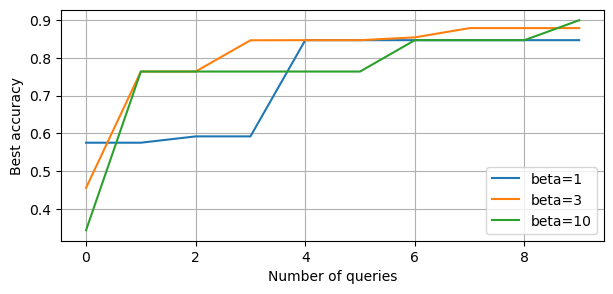

In [22]:
plt.figure(figsize=(7, 3))
for trial, beta in zip(range(num_experiments), betas):
    scores = incumbents[trial][:, 0]
    plt.plot(
        np.arange(num_queries),
        scores.numpy(),
        label=f"beta={beta}",
    )

plt.legend()
plt.grid(True)
plt.xlabel("Number of queries")
plt.ylabel("Best accuracy");

In [15]:
dim = 2
num_candidates = 2000

In [16]:
# Thompson Sampling
for trial in range(num_experiments):
    print(f"trial: {trial + 1}")
    torch.manual_seed(trial)

    # generate a random number between 0 and 2
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 2)
    train_y = accuracy_fn(train_x)

    for i in range(num_queries):
        incumbents[trial, i] = train_y.max()
    
        data = GPData(train_x, train_y, xs, ys)

        # run training loop to fit the GP
        model, likelihood = fit_gp_model(MaternGP, data)

        TS = botorch.generation.MaxPosteriorSampling(model, replacement=False)

        sobol = torch.quasirandom.SobolEngine(dim, scramble=True)
        candidate_x = sobol.draw(num_candidates)

        # Sobol generates samples that cover the unit cube. So we need to rescale them
        # to the desired bounds
        candidate_x = bounds[0] + (bounds[1] - bounds[0]) * candidate_x

        next_x = TS(candidate_x, num_samples=1)
        
        # visualization
        # visualize_gp_belief_and_policy(data, policy, next_x)
        
        # evaluate obj. func. at next_x and update training data
        next_y = accuracy_fn(next_x)

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

trial: 1


100%|██████████| 500/500 [00:00<00:00, 995.22it/s] 
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
100%|██████████| 500/500 [00:00<00:00, 750.79it/s]


trial: 2


100%|██████████| 500/500 [00:00<00:00, 753.51it/s]


trial: 3


100%|██████████| 500/500 [00:00<00:00, 738.06it/s]


In [27]:
mu = incumbents.mean(axis=0)
ci = 1.96 * incumbents.std(axis=0) / torch.sqrt(torch.tensor(num_experiments))

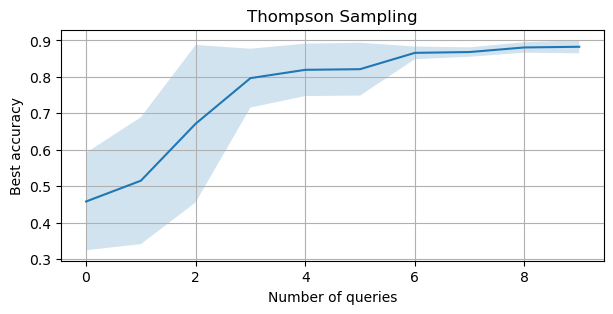

In [39]:
fig, ax = visualize_experiment(incumbents, num_queries, num_experiments)
ax.set_ylabel("Best accuracy")
ax.set_xlabel("Number of queries")
ax.set_title("Thompson Sampling");